# eMERGE Fagerstrom Test For Nicotine Dependence (FTND) GWAS
__Author:__ Jesse Marks


This document logs the steps taken to process the electronic Medical Records and Genomics (eMERGE) Network data and perform the FTND GWAS. The [eMERGE](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000360.v1.p1) Network is a consortium of five participating sites (Group Health Seattle, Marshfield Clinic, Mayo Clinic, Northwestern University, and Vanderbilt University). We will be processing the Marshfield cohort.

FTND is a standard instrument for assessing the physical addiction to nicotine. For more information, see [this website](https://cde.drugabuse.gov/instrument/d7c0b0f5-b865-e4de-e040-bb89ad43202b).

The genotype data were imputed on the [Michigan Imputation Server](https://imputationserver.sph.umich.edu/index.html).

* We use the variable `FTNDboth_cat` variable that lumps together the former smokers that have lifetime FTND (N=736) with the current smokers that have current FTND (N=78). This will optimize sample size, especially since the severe category is slim.

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* R packages: MASS, moments
* [RVtests](https://render.githubusercontent.com/view/ipynb?commit=3bb8e661ad8b75af027ed2748133452ec251aaed&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f525449496e7465726e6174696f6e616c2f6271756163685f6e6f7465626f6f6b732f336262386536363161643862373561663032376564323734383133333435326563323531616165642f6865726f696e5f70726f6a6563742f646576656c6f702f32303138303131305f756873325f756873335f666f755f677761732e6970796e623f746f6b656e3d41664d79344e373237626e764465456f46535a697770346b48776246577964706b7335617570495a7741253344253344&nwo=RTIInternational%2Fbquach_notebooks&path=heroin_project%2Fdevelop%2F20180110_uhs2_uhs3_fou_gwas.ipynb&repository_id=105297875&repository_type=Repository)

## FTNDboth_cat variable description
| cat | Freq |   |
|-----|------|---|
| 0   | 537  |   |
| 1   | 217  |   |
| 2   | 60   |   |

Where FTND conversion is 0=0-3, 1=4-6, and 2=7+

## Convert Phenotype Data from Strata format to .csv file

In [194]:
### R console ###
library(haven)

# convert Stata data into comma separated
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/eMerge/phenotype/') # local machine
pheno <- read_dta("FTND Phenotype.dta")
write.csv(pheno, file = "FTND_pheno.csv", row.names = F)
pheno.ftnd <- read.table("FTND_pheno.csv", header = T, sep = ",")
pheno.orig <- read.table("phs000170.v2.pht000737.v1.p1.c1.Marshfield_Data_Phenotype.HMB-GSO.txt", header = T)
num.subjects <- length(pheno.ftnd[['emergeid']])

pheno.combined <- data.frame(matrix(ncol = 4, nrow = num.subjects))
names(pheno.combined) <- c("emergeid", "sex", "age", "ftnd")
pheno.combined[1] <- pheno.ftnd[['emergeid']]
pheno.combined[4] <- pheno.ftnd[['FTNDboth_cat']]

# fill in sex and age data
for (i in 1:num.subjects) {
index <- match(pheno.ftnd[i,"emergeid"], pheno.orig[["SUBJID"]])
pheno.combined[i,"sex"] <- pheno.orig[index, "sex"]
pheno.combined[i,"age"] <- pheno.orig[index, "Age_First_Cataract_Diagnosis"]
}

table(pheno.ftnd[["FTNDboth_cat"]])


  0   1   2 
537 217  60 

[1] 2269

### Filter subjects missing any FTND, sex, or age data
Then write to file.

In [198]:
# Total subjects
length(pheno.ftnd[,1])

# filter out any subject with NA for FTND
filter_pheno <- pheno.combined[complete.cases(pheno.combined[,4]),]

# filtered due to missing ftnd data
length(pheno.combined[,1]) - length(filter_pheno[[4]])

# filter out any subject missing age data
drop_age <- suppressWarnings(which(is.na(as.numeric(as.character(filter_pheno[[3]])))))
filter_pheno <- filter_pheno[-drop_age,]

# filtered due to missing age data
length(drop_age)

# filter out any subject missing age data (There were no missing sex entries)
drop_sex <- which(filter_pheno[2] != "M" & filter_pheno[2] != "F")
#filter_pheno <- drop_sex[-drop_sex,]
# filtered due to missing sex data
length(drop_sex)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/eMerge/phenotype")
write.table(filter_pheno, "emerge_ftnd_filtered.txt", sep = " ", row.names = F, quote = F)

# subjects left
length(filter_pheno[,1])

[1] 2269

[1] 1455

[1] 307

[1] 0

[1] 507

* 507 subjects left, in total. 
* 1455 filtered due to NA in FTND data
* 307 were dropped due to missing age data.
* none were dropped due to missing sex data.

| Filtering Criterion | Subjects Removed  | Total |
|---------------------|-------------------|-------|
| Initial Data        | 0                 | 2269  |
| Missing FTND        | 1455              | 814   |
| Missing age         | 307               | 507   |
| Missing sex         | 0                 | 507   |

## Copy phenotype data to EC2

In [ ]:
### local machine ###
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/eMerge/phenotype
scp -i ~/.ssh/gwas_rsa emerge_ftnd_filtered.txt ec2-user@35.171.207.199:/shared/s3/emerge/data/phenotype

## Inflate imputation results

In [ ]:
### EC2 console ###
cd /shared/s3/emerge/data/genotype/imputed

# inflate chr results
for f in {1..22};do
echo '#!/bin/bash' > chr_$f.sh
echo '' >> chr_$f.sh
echo 'unzip -P "ScSu1byrJL49kO" chr_'$f'.zip' >> chr_$f.sh
done

for chr in {1..22}; do
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
--job_name inflate_chr${chr} \
--script_prefix chr${chr}_inflation \
--mem 5 \
--priority 0 \
--nslots 2 \
--program bash chr_${chr}.sh
done

## EIGENSTRAT
To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. Usually a GRCh37 plus strand check is implemented, as well as a monomorphic SNP filter and discordant allele flip. Since this was already done for data in preparation for haplotype phasing, the haplotype phasing input PLINK files will be used. Note: In addition to these aforementioned data processing steps, ambiguous SNPs identified by reference panel frequency differences in the discordant allele checks were also removed prior to phasing.

### Construct subject-filtered PLINK file sets

In [ ]:
# Command line #
mkdir -p /shared/s3/emerge/eigenstrat
cd /shared/s3/emerge/eigenstrat

#copy genotype data 
cp /shared/sandbox/emerge/ea_chr_all.* ../data/genotype/original/

# generate ID list to filter data with
cd /shared/s3/emerge/data/phenotype
awk ' NR>=2 { print $1 }' emerge_ftnd_filtered.txt > id_list.txt

grep -f id_list.txt ../genotype/original/ea_chr_all.fam > filtered.fam
awk '{print $1,$2 }' filtered.fam > ea_subject_ids.keep

# Remove subjects by phenotype criteria
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ../data/genotype/original/ea_chr_all \
    --keep ../data/phenotype/ea_subject_ids.keep \
    --make-bed \
    -out ${ancestry}_pheno_filter

__Note__: The phenotype data had 507 subjects while the genotype data only had 465 subjects.

### Remove high-LD region variants

In [ ]:
# Command line # 
cd /shared/s3/emerge/eigenstrat

# Remove high-LD region variants
ancestry="ea"
# Generate list of variants in known high-LD regions
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${ancestry}_pheno_filter.bim \
    > ${ancestry}.high_ld_regions.remove

# Remove SNPs in known high-LD regions
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}_pheno_filter \
    --exclude ${ancestry}.high_ld_regions.remove \
    --make-bed \
    --out ${ancestry}_pheno_filter_high_ld_regions_removed

## Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.`

In [ ]:
# Command line # 
cd /shared/s3/emerge/eigenstrat

# Remove high-LD region variants
ancestry="ea"
# Run per chromosome LD pruning for each chr
for chr in {1..23}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_ld_prune \
        --script_prefix ${ancestry}_${chr}_ld_prune \
        --mem 3.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3500 \
            --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out ${ancestry}_chr${chr}_ld_pruned
done


#Create LD pruned PLINK file sets
ancestry="ea"
# Merge *prune.in files
cat ${ancestry}_chr*_ld_pruned.prune.in > ${ancestry}_chr_all_ld_pruned.prune.in

# Create new PLINK filesets with only lD pruned variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
    --extract ${ancestry}_chr_all_ld_pruned.prune.in \
    --make-bed \
    --out ${ancestry}_ld_pruned


# Clean up
rm *ld_pruned.{prune.in,prune.out,log}
rm *qsub*
rm *high_ld_regions*
rm *nosex
rm *pheno_filter*

## Rename BIM/FAM file IDs
BIM and FAM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause `smartpca` to throw an error. To resolve this the IDs are replaced by numeric values if needed.

In [ ]:
# Command line # 
cd /shared/s3/emerge/eigenstrat

# Count ID lengths greater than 39 characters
ancestry="ea"
echo -e "\n\n======== ${ancestry} ========\n\n"
awk '{ if(length($1)+length($2)>39){print $2} }' ${ancestry}_ld_pruned.fam | wc -l
awk '{ if(length($2)>39){print $2} }' ${ancestry}_ld_pruned.bim | wc -l

# Rename BIM file IDs
# Make new BIM
#awk '{$2="ID_"NR; print $0}' ${ancestry}_ld_pruned.bim \
#    > ${ancestry}_ld_pruned_id_renamed.bim

# Rename FAM file IDs
# Make new FAM
#awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam \
#   > ${ancestry}_ld_pruned_id_renamed.fam

__Note__ we did not have to rename the BIM or FAM files for this case. 

### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

`export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/` # Add EIGENSOFT bin to path

The `smartpca.pl` program documentation is shown below:


DOCUMENTATION of `smartpca.pl` program:

This program calls the `smartpca` program (see ../POPGEN/README). 
For this to work, the bin directory containing `smartpca` MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
# Command line # 
cd /shared/s3/emerge/eigenstrat
mkdir results

# Run EIGENSTRAT smartpca 
ancestry="ea"
# Run smartpca
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_smartpca \
    --script_prefix results/smartpca_${ancestry} \
    --mem 13.5 \
    --nslots 2 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i ${ancestry}_ld_pruned.bed \
        -a ${ancestry}_ld_pruned.bim \
        -b ${ancestry}_ld_pruned.fam \
        -o results/${ancestry}_ld_pruned.pca \
        -p results/${ancestry}_ld_pruned.plot \
        -e results/${ancestry}_ld_pruned.eval \
        -l results/${ancestry}_ld_pruned.pca.log \
        -m 0

### PCA Plot
Copy results over to local machine so we can visualize the results

In [ ]:
## local machine ##
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/emerge/eigenstrat/results/ea_ld_pruned.pca.evec \
    /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/eMerge/eigenstrat

In [162]:
## R console ##
# Load PCA data
setwd(dir = "C:/Users/jmarks/Desktop/Projects/Nicotine/eMerge/eigenstrat/")
options(stringsAsFactors=F)
ea.evec <- read.table("ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
ea.evec[1:5,]

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
EMERGE-3:16218877,0.0038,0.0052,-0.0029,-0.0085,0.0076,-0.0214,-0.0088,-0.0512,0.0022,0.0223,???
EMERGE-3:16230920,0.0061,-0.0224,0.0197,0.0300,0.0184,-0.0190,0.0158,-0.0322,-0.0148,-0.0167,???
EMERGE-8:16220003,-0.0202,0.0155,0.0050,0.0046,-0.0022,-0.0117,-0.0437,0.0036,0.0089,0.0119,???
EMERGE-11:16217471,-0.0087,-0.0060,-0.0131,0.0089,0.0254,-0.0462,0.0149,-0.0432,0.0180,0.0363,???
EMERGE-11:16218001,-0.0020,-0.0111,0.0074,0.0021,-0.0149,-0.0178,-0.0361,0.0065,-0.0105,-0.0393,???


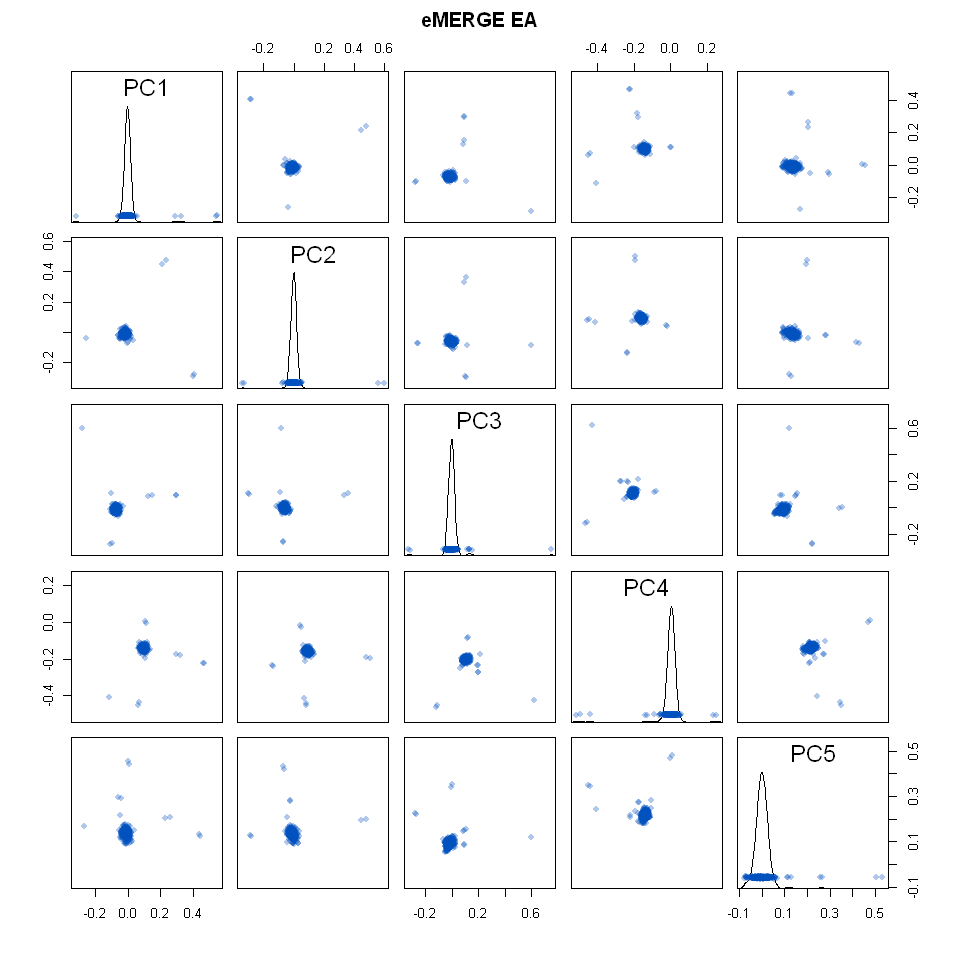

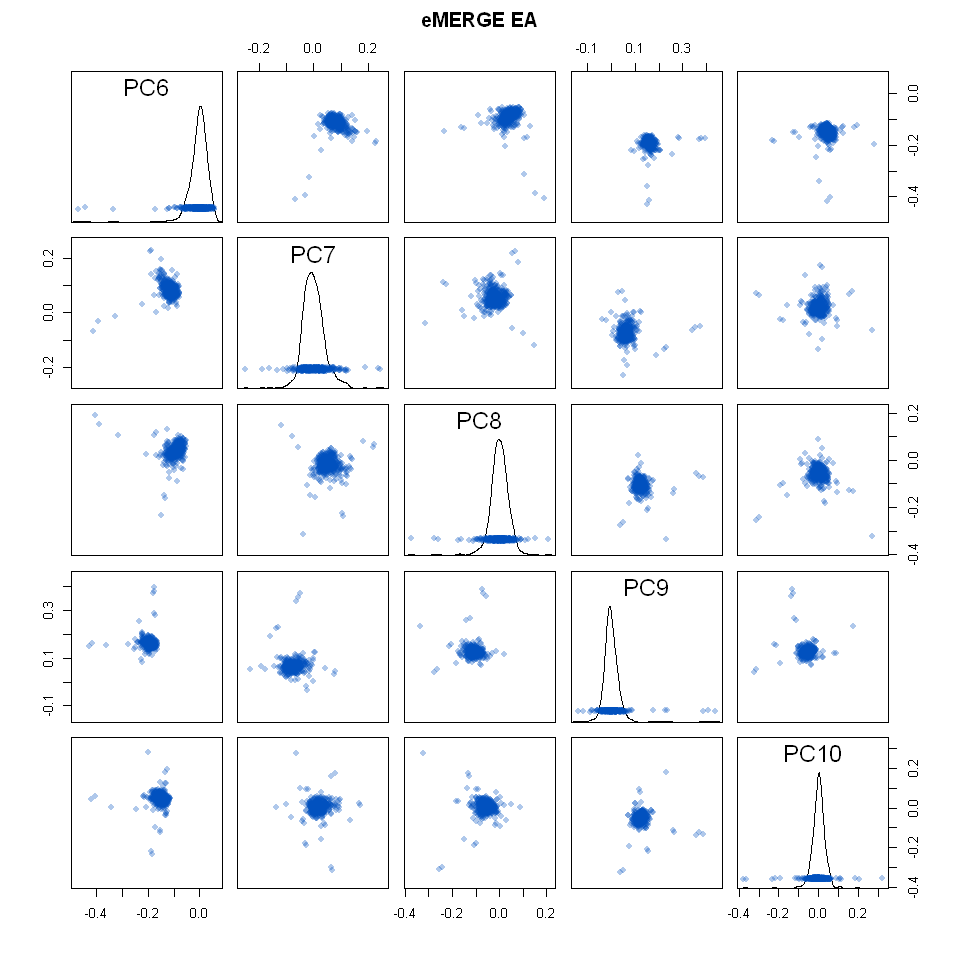

In [163]:
### R console ###

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="eMERGE EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="eMERGE EA", cex.main=1)

### Extract eigenvectors

In [ ]:
# Command line # 
cd /shared/s3/emerge/eigenstrat/results

# Grab top 10 eigenvectors from PCA 
ancestry="ea"
# Extract eigenvectors
echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${ancestry}_ld_pruned_top10_eigenvecs.txt
tail -n +2 ${ancestry}_ld_pruned.pca.evec | \
    perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
    >> ${ancestry}_ld_pruned_top10_eigenvecs.txt

## Phenotype processing
### Retrieve covariates and generate mapping file
The covariates we want to include are age and sex. Sex is encoded as M=Male and F=Female. 


#### Create ped file

In [ ]:
# Command line # 
cd /shared/s3/emerge/data/phenotype

### R ###
p.data <- "emerge_ftnd_filtered.txt"
pheno.data <- read.csv(p.data, sep = " ", header = T, stringsAsFactors = F, 
                       colClasses=c("integer", "character", "integer", "integer"))

pca.data <- read.csv("../../eigenstrat/results/ea_ld_pruned_top10_eigenvecs.txt", sep = " " , 
                    colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects <- length(pca.data[,1])

ped.file <- data.frame(matrix(ncol = 7, nrow = num.subjects))
colnames(ped.file) <- c("fid", "iid", "patid", "matid", "sex",  "ftnd", "age")
ped.file[,1] <- pca.data[,1]
ped.file[,2] <- pca.data[,2]

# map loop (goal to fill in sex age, and ftnd data on ped.file from the pheno.data)
for (i in 1:num.subjects){
    key <- noquote(ped.file[i,2])
    
    my_match <- match(key, pheno.data[,1])
    ped.file[i,5] <- pheno.data[my_match,2]
    ped.file[i,6] <- pheno.data[my_match,4]
    ped.file[i,7] <- pheno.data[my_match,3]
    
} # end i loop

write.table(ped.file[,1:6], "eMERGE_EUR_phen.ped", sep = "\t", row.names = F, quote=F)

#### Create cov file

In [ ]:
covar.data <- data.frame(matrix(ncol = 16, nrow = num.subjects))
colnames(covar.data) <- c("fid", "iid", "patid", "matid", "sex", "age", 
                        "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
covar.data[,1:5] <- ped.file[,1:5]
covar.data[,6] <- ped.file[,7]

covar.data[,7:length(covar.data)] <- pca.data[,3:length(pca.data)]

write.table(covar.data, "eMERGE_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

## PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

__Note__: we will perform this on our local machine for convenience.

In [ ]:
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/eMerge/phenotype
scp  -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/emerge/data/phenotype/eMERGE* .

In [164]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/eMerge/phenotype')
options(stringsAsFactors=F)
ea.cov.data <- read.delim("eMERGE_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("eMERGE_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "ftnd"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")

## Regression analysis
We use a regression model of the general structure
\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}

In [165]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 ftnd ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6090 -0.4094 -0.3656  0.5761  1.6837 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.39014    0.02820  13.833   <2e-16 ***
PC1         -1.14680    0.60643  -1.891   0.0593 .  
PC2         -0.08045    0.60764  -0.132   0.8947    
PC3          1.33007    0.65308   2.037   0.0423 *  
PC4         -0.64129    0.74269  -0.863   0.3883    
PC5         -0.72455    0.75460  -0.960   0.3375    
PC6          0.91615    0.61342   1.494   0.1360    
PC7          0.14748    0.63624   0.232   0.8168    
PC8          0.14684    0.61319   0.239   0.8109    
PC9          0.02182    0.60708   0.036   0.9713    
PC10         0.54465    0.60568   0.899   0.3690    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6054 on 451 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.0

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC3,1,1.6984074683,1.6984074683,4.634444529,0.03186602,35.32
PC1,1,1.3197970814,1.3197970814,3.601330351,0.05837168,27.45
PC6,1,0.8395773757,0.8395773757,2.290954820,0.13083029,17.46
PC4,1,0.3017800196,0.3017800196,0.823467152,0.36465300,6.28
PC5,1,0.3001552471,0.3001552471,0.819033635,0.36594605,6.24
PC10,1,0.2963442956,0.2963442956,0.808634692,0.36900407,6.16
PC8,1,0.0206918444,0.0206918444,0.056461837,0.81228607,0.43
PC7,1,0.0170003505,0.0170003505,0.046388857,0.82956786,0.35
PC2,1,0.0143163060,0.0143163060,0.039064905,0.84340918,0.30
PC9,1,0.0005070603,0.0005070603,0.001383616,0.97034440,0.01


## Percent Variance Explained Visualization

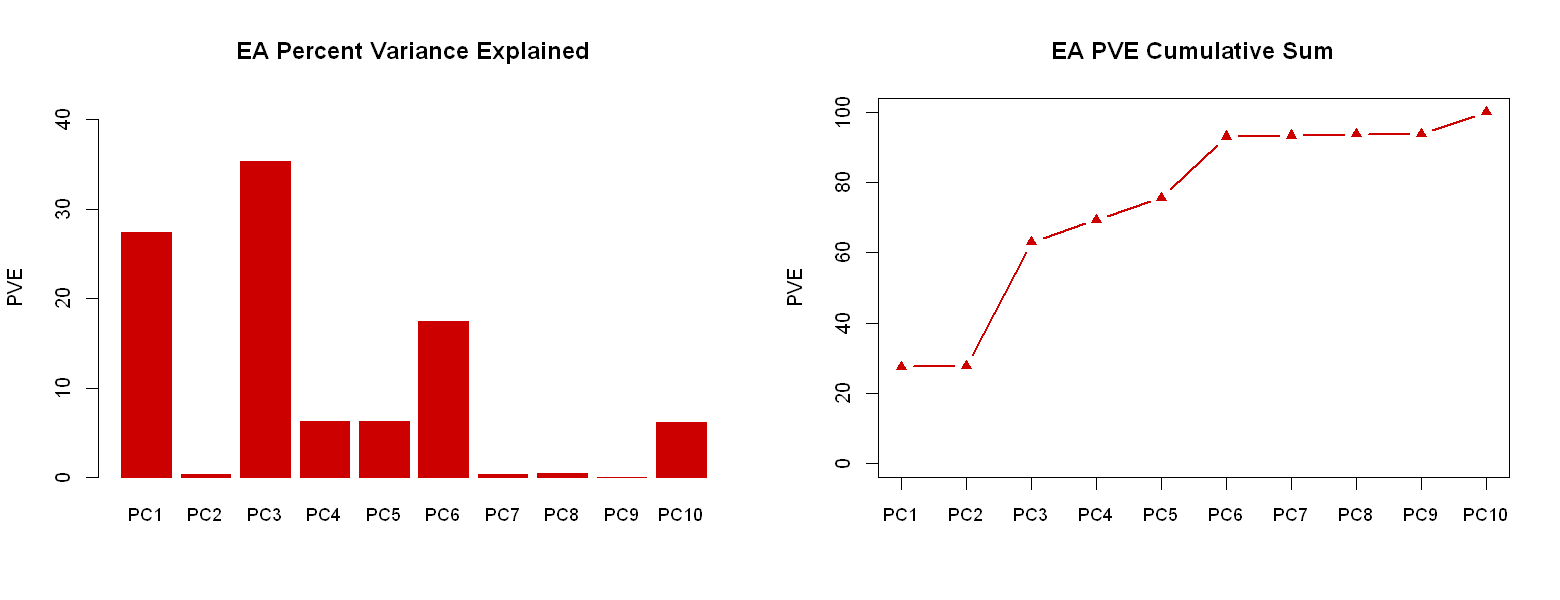

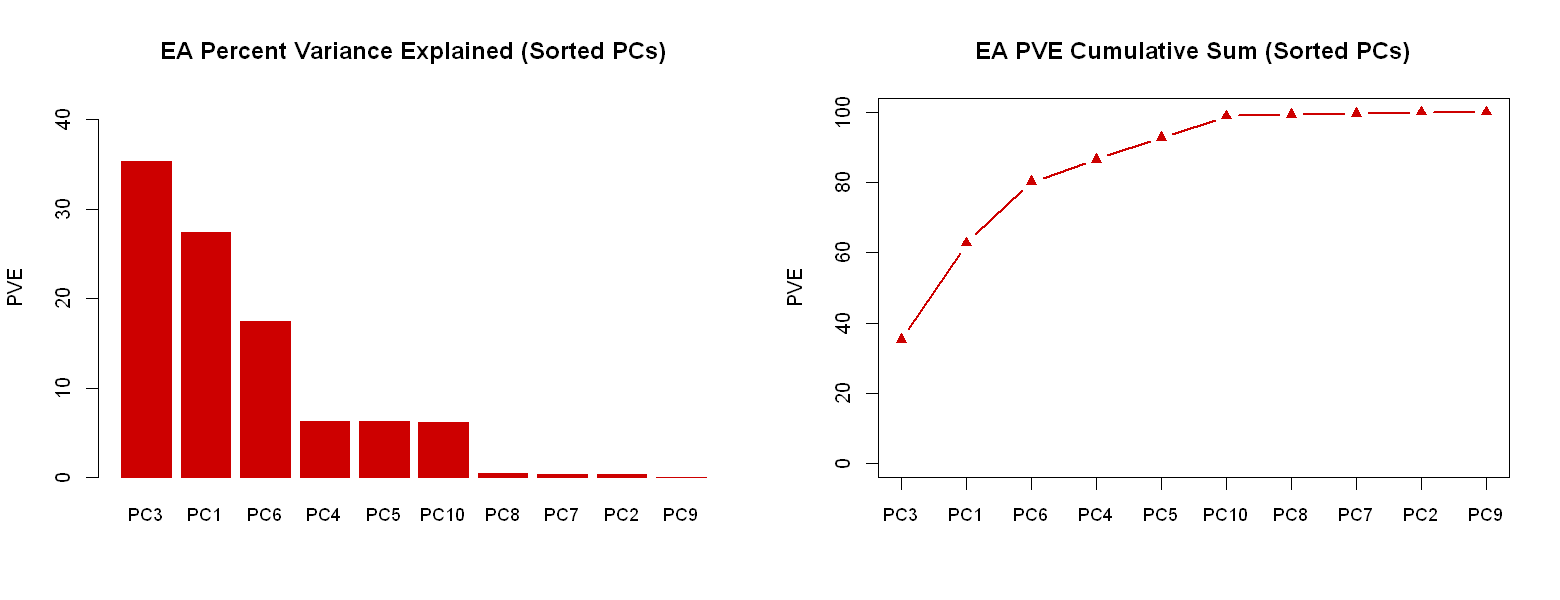

In [166]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)

Based on these results, we will use PC3, PC1, and PC6 in the GWAS as covariates. These PCs contribute to >75% of the percent variance explained.

## Run GWAS
Need to convert the imputed data files from VCF format to mldose. We will be using the NextFlow pipeline, which has been tailored to expect ouput from IMPUTE2 that has been converted to mldose format. 

In [ ]:
### EC2 console ###
cd /shared/s3/emerge/data
mkdir assoc_tests




## S3 data transfer

In [ ]:
# Copy phenotype data
cd /shared/s3/emerge/data/phenotype
aws s3 cp ./ s3://rti-nd/eMERGE/emerge_ftnd/data/phenotype \
    --recursive --exclude="*" --include="*ped.gz" --quiet &

cd /shared/s3/emerge_ftnd/data/assoc_tests
# Copy association test results
aws s3 cp ./ s3://rti-nd/eMERGE/emerge_ftnd/results/rvtest/ \
    --recursive --exclude="*" --include="*MetaScore*gz*" --quiet &
aws s3 cp ./ s3://rti-nd/eMERGE/emerge_ftnd/results/figures/ \
    --recursive --exclude="*" --include="*.png.gz" --quiet &






ancestry=ea
# copy imputation files
cd /shared/sandbox/emerge_ftnd/genotype/imputed/

# chrX (male) data
aws s3 cp chrX.no.auto_male.dose.vcf.gz.tbi s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_male.dose.vcf.gz.tbi 
aws s3 cp chrX.no.auto_male.dose.vcf.gz s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_male.dose.vcf.gz --quiet &     
aws s3 cp chrX.no.auto_male.info.gz s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_male.info.gz --quiet &     

# chrX (female) data
aws s3 cp chrX.no.auto_female.dose.vcf.gz.tbi s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_female.dose.vcf.gz.tbi 
aws s3 cp chrX.no.auto_female.dose.vcf.gz s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_female.dose.vcf.gz --quiet &     
aws s3 cp chrX.no.auto_female.info.gz s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/ea/chrX.no.auto_female.info.gz --quiet &     


aws s3 cp snp_stats/ s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/${ancestry}/ \
    --recursive --exclude "*" --include "*.txt" --quiet &
aws s3 cp qc_report/ s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/${ancestry}/ \
    --recursive --exclude "*" --include "*.html" --quiet &
aws s3 cp logs/ s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/${ancestry}/ \
    --recursive --exclude "*" --include "*.log" --quiet &

# submit upload as a job
--------------------------------------------------------------------------------
## copy imputation files
/shared/s3/emerge/data/genotype/imputed
ancestry=ea
for ext in {\"*.info.gz\",\"*dose.vcf.gz\",\"*dose.vcf.gz.tbi\",\"*.txt\"}; do
/shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name s3_upload_emerge \
        --script_prefix _${ext} \
        --mem 5 \
        --nslots 1 \
        --program "aws s3 cp . s3://rti-nd/eMERGE/emerge_ftnd/data/genotype/imputed/${ancestry}/ \
            --recursive --exclude \"*\" --include $ext "
done
            